In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Các thư viện Scikit-learn (sklearn) cho Phân loại
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Tắt cảnh báo
import warnings
warnings.filterwarnings('ignore')

# --- Tải Dữ liệu ---
file_path = 'maternal_health_risk_data.csv'
df = pd.read_csv(file_path)

print("Tải dữ liệu thành công!")
print(df.head())
print("\nThông tin dữ liệu:")
print(df.info())

Tải dữ liệu thành công!
   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage

--- Yêu cầu 1: Biểu diễn dữ liệu ---

Cột mục tiêu đã được mã hóa: [('high risk', 0), ('low risk', 1), ('mid risk', 2)]


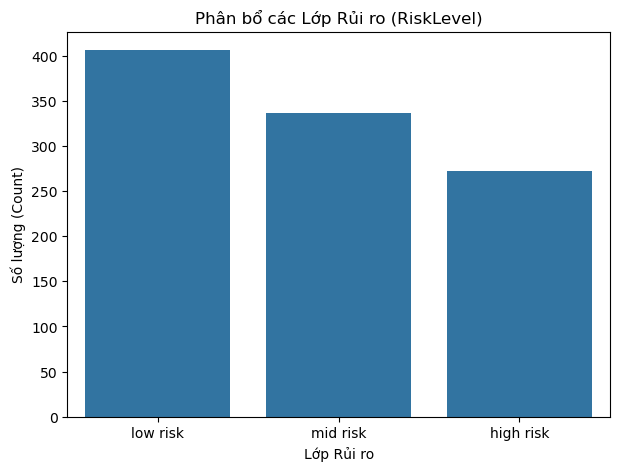

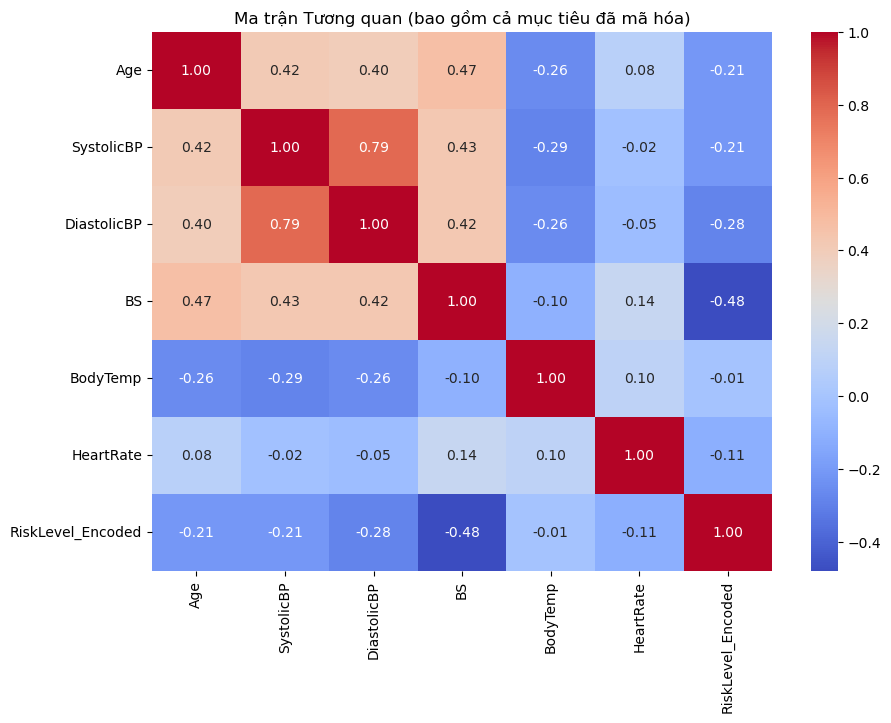

In [3]:
print("--- Yêu cầu 1: Biểu diễn dữ liệu ---")

# 1. Tiền xử lý nhanh: Mã hóa cột mục tiêu 'RiskLevel'
# Máy tính không hiểu chữ 'high risk', 'low risk', 'mid risk'
target_encoder = LabelEncoder()
df['RiskLevel_Encoded'] = target_encoder.fit_transform(df['RiskLevel'])

# Lấy X (đặc trưng) và y (mục tiêu đã mã hóa)
X = df.drop(['RiskLevel', 'RiskLevel_Encoded'], axis=1)
y = df['RiskLevel_Encoded']
target_names = target_encoder.classes_ # Lưu lại tên gốc: ['high risk', 'low risk', 'mid risk']

print(f"\nCột mục tiêu đã được mã hóa: {list(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))}")

# 2. Vẽ biểu đồ Phân bổ Mục tiêu (Kiểm tra mất cân bằng)
plt.figure(figsize=(7, 5))
sns.countplot(x='RiskLevel', data=df, order=df['RiskLevel'].value_counts().index)
plt.title('Phân bổ các Lớp Rủi ro (RiskLevel)')
plt.xlabel('Lớp Rủi ro')
plt.ylabel('Số lượng (Count)')
plt.savefig("maternal_risk_distribution.png") # Lưu hình ảnh
plt.show()

# 3. Vẽ biểu đồ Tương quan (Heatmap)
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Ma trận Tương quan (bao gồm cả mục tiêu đã mã hóa)')
plt.savefig("maternal_correlation_heatmap.png") # Lưu hình ảnh
plt.show()

--- Yêu cầu 2 & 3: Huấn luyện và Đánh giá (Mô hình KNN cơ sở) ---
Đã chia và chuẩn hóa dữ liệu.
Đã huấn luyện xong mô hình KNN (K=5).

--- Báo cáo Phân loại (Mô hình KNN K=5) ---
              precision    recall  f1-score   support

   high risk       0.87      0.73      0.79        55
    low risk       0.64      0.74      0.69        81
    mid risk       0.57      0.54      0.55        67

    accuracy                           0.67       203
   macro avg       0.69      0.67      0.68       203
weighted avg       0.68      0.67      0.67       203

--- Ma trận Nhầm lẫn (Mô hình KNN K=5) ---


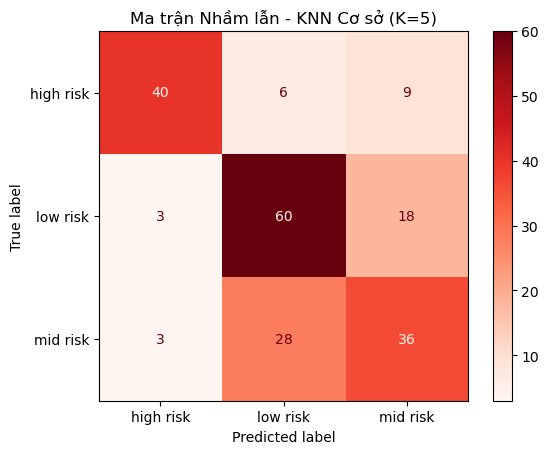

In [5]:
print("--- Yêu cầu 2 & 3: Huấn luyện và Đánh giá (Mô hình KNN cơ sở) ---")

# --- Chia dữ liệu ---
# QUAN TRỌNG: Dùng 'stratify=y' vì dữ liệu mất cân bằng
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

# --- Chuẩn hóa dữ liệu ---
# KNN rất nhạy cảm với thang đo, nên bước này là BẮT BUỘC
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Đã chia và chuẩn hóa dữ liệu.")

# --- Yêu cầu 2: Huấn luyện mô hình ---
# Dùng K=5 làm giá trị cơ sở
model_knn_baseline = KNeighborsClassifier(n_neighbors=5)
model_knn_baseline.fit(X_train_scaled, y_train)
print("Đã huấn luyện xong mô hình KNN (K=5).")

# --- Yêu cầu 3: Đánh giá mô hình ---
y_pred_baseline = model_knn_baseline.predict(X_test_scaled)

# 3.1. Dùng Classification Report [cite: 11519-11527]
print("\n--- Báo cáo Phân loại (Mô hình KNN K=5) ---")
print(classification_report(y_test, y_pred_baseline, target_names=target_names))

# 3.2. Dùng Confusion Matrix [cite: 11450-11451]
print("--- Ma trận Nhầm lẫn (Mô hình KNN K=5) ---")
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=target_names)
disp.plot(cmap="Reds")
plt.title("Ma trận Nhầm lẫn - KNN Cơ sở (K=5)")
plt.savefig("maternal_baseline_cm.png") # Lưu hình ảnh
plt.show()

--- Yêu cầu 4: Tinh chỉnh Mô hình (Grid Search với KNN) ---
(Mục tiêu: weighted avg f1-score >= 0.70 | Điểm cơ sở: ~0.67)
Bắt đầu Grid Search...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Grid Search hoàn tất!
Các tham số tốt nhất tìm được: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}

--- Báo cáo Phân loại (Mô hình TỐT NHẤT sau Tinh chỉnh) ---
              precision    recall  f1-score   support

   high risk       0.89      0.93      0.91        55
    low risk       0.81      0.73      0.77        81
    mid risk       0.73      0.79      0.76        67

    accuracy                           0.80       203
   macro avg       0.81      0.82      0.81       203
weighted avg       0.80      0.80      0.80       203


Weighted Avg F1-Score cuối cùng: 0.8024
CHÚC MỪNG! Đã đạt được giá trị kỳ vọng (f1-score >= 0.70)


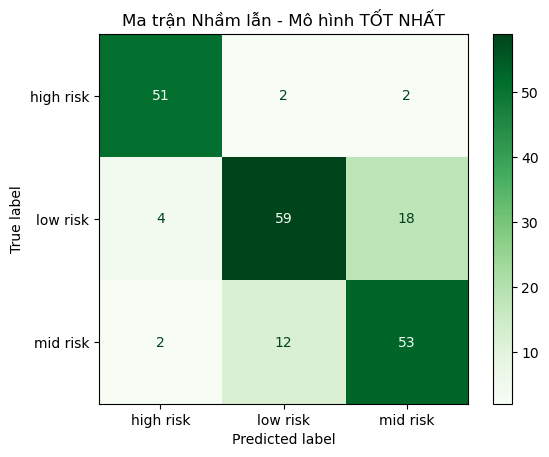

In [7]:
print("--- Yêu cầu 4: Tinh chỉnh Mô hình (Grid Search với KNN) ---")
print(f"(Mục tiêu: weighted avg f1-score >= 0.70 | Điểm cơ sở: ~0.67)")

# 1. Định nghĩa không gian tham số (param_grid)
# Chúng ta sẽ thử các giá trị K, cách tính trọng số, và thước đo khoảng cách
param_grid = {
    'n_neighbors': [3, 5, 7, 9],           # Thử các giá trị K
    'weights': ['uniform', 'distance'],    # 'uniform': các điểm bằng nhau
                                           # 'distance': điểm gần hơn có trọng số cao hơn
    'metric': ['euclidean', 'manhattan']   # Các cách đo khoảng cách
}

# 2. Khởi tạo GridSearchCV
# cv=5 (5-fold cross-validation)
# scoring='f1_weighted' (chỉ số chúng ta muốn tối ưu)
grid_search = GridSearchCV(KNeighborsClassifier(), 
                           param_grid, 
                           cv=5, 
                           scoring='f1_weighted', 
                           verbose=1) # verbose=1 để in ra quá trình

print("Bắt đầu Grid Search...")
grid_search.fit(X_train_scaled, y_train)

# 3. In ra kết quả tốt nhất
print("\nGrid Search hoàn tất!")
print(f"Các tham số tốt nhất tìm được: {grid_search.best_params_}")

# 4. Lấy mô hình tốt nhất đã được huấn luyện
best_model = grid_search.best_estimator_

# --- Đánh giá lại mô hình TỐT NHẤT trên tập TEST ---
y_pred_best = best_model.predict(X_test_scaled)

print("\n--- Báo cáo Phân loại (Mô hình TỐT NHẤT sau Tinh chỉnh) ---")
final_report = classification_report(y_test, y_pred_best, target_names=target_names)
print(final_report)

# Lấy điểm F1-score từ báo cáo
report_dict = classification_report(y_test, y_pred_best, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']

print(f"\nWeighted Avg F1-Score cuối cùng: {weighted_f1:.4f}")
if weighted_f1 >= 0.70:
    print("CHÚC MỪNG! Đã đạt được giá trị kỳ vọng (f1-score >= 0.70)")
else:
    print("CHƯA ĐẠT MỤC TIÊU.")

# Vẽ ma trận nhầm lẫn
cm_best = confusion_matrix(y_test, y_pred_best)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=target_names)
disp_best.plot(cmap="Greens")
plt.title(f"Ma trận Nhầm lẫn - Mô hình TỐT NHẤT")
plt.savefig("maternal_tuned_cm.png") # Lưu hình ảnh
plt.show()